# Capstone Project - The Battle of the Neighborhoods (Week 2)


### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

The main objective of this project is to determine the safest place in terms of the criminal situation for opening a business in Denver, USA.

First, needed to choose the safest borough with a sufficient list of neighborhoods for business development by analysing crime data. We will use the studied course material and such standard libraries as pandas, numpy, matplotlib, etc. We will focus on finding the safest borough and its neighbourhoods, where few grocery stores.

## Data <a name="data"></a>

Based on the problem, we must: Find the safest area with a enough list of neighborhoods Identify its most common places

We will use the geographical coordinates of the city of Denver and the coordinates of the crimes recorded from 1st January 2015 to 17 July 2020.

Following data sources will be needed to extract/generate the required information:

https://www.kaggle.com/paultimothymooney/denver-crime-data dataset include type, date and location of crime in Denver.

https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Denver There we have a neighbourhoods and which borough they include.

Also, we will needed to create a new dataset of the Neighborhoods, boroughs, and the most common venues and the respective Neighbourhood along with coordinates. This data will be fetched using Foursquare API to explore the neighbourhood venues and to apply machine learning algorithm to cluster the neighbourhoods and present the findings by plotting it on maps using Folium.

In [2]:
import numpy as np
import pandas as pd

#Command to install OpenCage Geocoder for fetching Lat and Lng of Neighborhood
!pip install opencage

#Importing OpenCage Geocoder
from opencage.geocoder import OpenCageGeocode

# use the inline backend to generate the plots within the browser
%matplotlib inline 

#Importing Matplot lib and associated packages to perform Data Visualisation and Exploratory Data Analysis
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#Importing folium to visualise Maps and plot based on Lat and Lng
import folium

#Requests to request web pages by making get requests to FourSquare REST Client
import requests

#To normalise data returned by FourSquare API
from pandas.io.json import json_normalize

#Importing KMeans from SciKit library to Classify neighborhoods into clusters
from sklearn.cluster import KMeans

print('Libraries imported')

Matplotlib version:  3.1.3
Libraries imported


## Load data

In [3]:
df_mn = pd.read_csv(r'C:\Users\Archy\Desktop\Projects\crime.csv')
df_mn.head()


,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC
0,2018869789,2018869789239900,2399,0,theft-other,larceny,12/27/2018 3:58:00 PM,NaN,12/27/2018 4:51:00 PM,2681 N HANOVER CT,3178210.0,1700715.0,-104.866156,39.755561,5,512,stapleton,1,0
1,2015664356,2015664356544100,5441,0,traffic-accident,traffic-accident,11/13/2015 7:45:00 AM,NaN,11/13/2015 8:38:00 AM,4100 BLOCK W COLFAX AVE,3129148.0,1694748.0,-105.040760,39.739991,1,122,west-colfax,0,1
2,20176005213,20176005213239901,2399,1,theft-bicycle,larceny,6/8/2017 1:15:00 PM,6/8/2017 5:15:00 PM,6/12/2017 8:44:00 AM,1705 17TH ST,3140790.0,1699792.0,-104.999264,39.753669,6,612,union-station,1,0
3,20196012240,20196012240230800,2308,0,theft-from-bldg,larceny,12/7/2019 1:07:00 PM,12/7/2019 6:30:00 PM,12/9/2019 1:35:00 PM,1350 N IRVING ST,3132400.0,1694088.0,-105.029208,39.738134,1,122,west-colfax,1,0
4,2018861883,2018861883501600,5016,0,violation-of-restraining-order,all-other-crimes,12/22/2018 8:15:00 PM,12/22/2018 8:31:00 PM,12/22/2018 10:00:00 PM,13625 E RANDOLPH PL,3188580.0,1716158.0,-104.828868,39.797750,5,521,montbello,1,0


## Drop columns that not important for us

In [4]:
df_mn.drop(['INCIDENT_ID','OFFENSE_ID', 'OFFENSE_CODE', 'OFFENSE_CODE_EXTENSION', 'OFFENSE_CATEGORY_ID', 'LAST_OCCURRENCE_DATE', 'INCIDENT_ADDRESS', 'GEO_X', 'GEO_Y', 'PRECINCT_ID', 'IS_CRIME', 'IS_TRAFFIC', 'DISTRICT_ID', 'REPORTED_DATE'], axis=1, inplace = True)

In [5]:
df_mn

,OFFENSE_TYPE_ID,FIRST_OCCURRENCE_DATE,GEO_LON,GEO_LAT,NEIGHBORHOOD_ID
0,theft-other,12/27/2018 3:58:00 PM,-104.866156,39.755561,stapleton
1,traffic-accident,11/13/2015 7:45:00 AM,-105.040760,39.739991,west-colfax
2,theft-bicycle,6/8/2017 1:15:00 PM,-104.999264,39.753669,union-station
3,theft-from-bldg,12/7/2019 1:07:00 PM,-105.029208,39.738134,west-colfax
4,violation-of-restraining-order,12/22/2018 8:15:00 PM,-104.828868,39.797750,montbello
...,...,...,...,...,...
492606,theft-other,6/5/2020 3:00:00 PM,-104.995758,39.759856,five-points
492607,theft-of-motor-vehicle,5/29/2020 9:00:00 PM,-104.847803,39.783106,montbello
492608,criminal-mischief-mtr-veh,5/31/2020 7:10:00 PM,-104.975171,39.744151,north-capitol-hill
492609,theft-items-from-vehicle,6/10/2020 10:15:00 PM,-104.917270,39.654625,hampden


In [6]:
df_mn.columns = ['Type', 'Date', 'Lon','Lat','Neighbourhood']
df_mn.head()

,Type,Date,Lon,Lat,Neighbourhood
0,theft-other,12/27/2018 3:58:00 PM,-104.866156,39.755561,stapleton
1,traffic-accident,11/13/2015 7:45:00 AM,-105.040760,39.739991,west-colfax
2,theft-bicycle,6/8/2017 1:15:00 PM,-104.999264,39.753669,union-station
3,theft-from-bldg,12/7/2019 1:07:00 PM,-105.029208,39.738134,west-colfax
4,violation-of-restraining-order,12/22/2018 8:15:00 PM,-104.828868,39.797750,montbello


## Let's make a simple column about year of crime instead full date

In [7]:
df_mn['Year'] = pd.DatetimeIndex(df_mn['Date']).year

## Data normalization

In [8]:
df_mn['Neighbourhood'] = df_mn['Neighbourhood'].str.replace('-',' ')
df_mn['Type'] = df_mn['Type'].str.replace('-',' ')
df_mn.head()

,Type,Date,Lon,Lat,Neighbourhood,Year
0,theft other,12/27/2018 3:58:00 PM,-104.866156,39.755561,stapleton,2018
1,traffic accident,11/13/2015 7:45:00 AM,-105.040760,39.739991,west colfax,2015
2,theft bicycle,6/8/2017 1:15:00 PM,-104.999264,39.753669,union station,2017
3,theft from bldg,12/7/2019 1:07:00 PM,-105.029208,39.738134,west colfax,2019
4,violation of restraining order,12/22/2018 8:15:00 PM,-104.828868,39.797750,montbello,2018


In [9]:
df_mn['Neighbourhood'] = df_mn['Neighbourhood'].str.title()
df_mn['Type'] = df_mn['Type'].str.title()

df_mn

,Type,Date,Lon,Lat,Neighbourhood,Year
0,Theft Other,12/27/2018 3:58:00 PM,-104.866156,39.755561,Stapleton,2018
1,Traffic Accident,11/13/2015 7:45:00 AM,-105.040760,39.739991,West Colfax,2015
2,Theft Bicycle,6/8/2017 1:15:00 PM,-104.999264,39.753669,Union Station,2017
3,Theft From Bldg,12/7/2019 1:07:00 PM,-105.029208,39.738134,West Colfax,2019
4,Violation Of Restraining Order,12/22/2018 8:15:00 PM,-104.828868,39.797750,Montbello,2018
...,...,...,...,...,...,...
492606,Theft Other,6/5/2020 3:00:00 PM,-104.995758,39.759856,Five Points,2020
492607,Theft Of Motor Vehicle,5/29/2020 9:00:00 PM,-104.847803,39.783106,Montbello,2020
492608,Criminal Mischief Mtr Veh,5/31/2020 7:10:00 PM,-104.975171,39.744151,North Capitol Hill,2020
492609,Theft Items From Vehicle,6/10/2020 10:15:00 PM,-104.917270,39.654625,Hampden,2020


In [10]:
df_mn['Neighbourhood'].value_counts()

Five Points     26724
Stapleton       21686
Cbd             17630
Capitol Hill    17562
Montbello       16759
                ...  
Skyland          1955
Rosedale         1591
Country Club     1127
Wellshire         606
Indian Creek      576
Name: Neighbourhood, Length: 78, dtype: int64

## Make a dataframe with boroughs and neighbourhoods of Denver

In [11]:
column_names = ['Neighbourhood', 'Borough'] 

# instantiate the dataframe
dnv_nbr = pd.DataFrame(columns=column_names)

dnv_nbr['Neighbourhood'] = df_mn['Neighbourhood'].unique()

dnv_nbr_dict = {'Baker':'Central', 'Capitol Hill':'Central', 'Central Business District':'Central', 'Cherry Creek':'Central',
                'Cheesman Park':'Central', 'City Park':'Central', 'Congress Park':'Central', 'City Park West':'Central',
                'Civic Center':'Central', 'Country Club':'Central', 'Lincoln Park':'Central', 'North Capitol Hill':'Central', 
                'Speer':'Central', 'Union Station':'Central', 'Belcaro': 'East', 'Cory-Merrill': 'East', 'East Colfax': 'East',
                'Hale': 'East', 'Hilltop': 'East', 'Indian Creek': 'East', 'Lowry': 'East', 'Montclair': 'East', 'Park Hill': 'East',
                'Virginia Village': 'East', 'Washington Virginia Vale': 'East', 'Windsor': 'East','Clayton':'North', 'Cole':'North',
                'Elyria-Swansea':'North', 'Five Points':'North', 'Globeville':'North', 'North Park Hill':'North', 'South Park Hill':'North',
                'Skyland':'North', 'Whittier':'North','Denver International Airport':'Northeast', 'Gateway / Green Valley Ranch':'Northeast',
                'Montbello':'Northeast', 'Northeast Park Hill':'Northeast', 'Stapleton':'Northeast','Auraria':'Northwest', 'Berkeley':'Northwest',
                'Chaffee Park':'Northwest', 'Highland':'Northwest', 'Jefferson Park':'Northwest', 'Regis':'Northwest', 'Sloan Lake':'Northwest',
                'Sunnyside':'Northwest', 'West Highland':'Northwest','College View / South Platte':'South', 'Overland':'South', 'Platt Park':'South',
                'Rosedale':'South', 'University':'South', 'University Hills':'South', 'University Park':'South', 'Washington Park':'South',
                'Washington Park West':'South', 'Wellshire':'South','Goldsmith':'Southeast', 'Hampden':'Southeast', 'Hampden South':'Southeast', 'Kennedy':'Southeast',
                'Southmoor Park':'Southeast','Bear Valley':'Southwest', 'Fort Logan':'Southwest', 'Harvey Park':'Southwest', 'Harvey Park South':'Southwest', 'Marston':'Southwest',
               'Athmar Park':'West', 'Barnum':'West', 'Barnum West':'West', 'Mar Lee':'West', 'Ruby Hill':'West', 'Sun Valley':'West', 'Valverde':'West', 'Villa Park':'West', 'West Colfax':'West', 'Westwood':'West'}

for row, neigh in zip(dnv_nbr_dict, dnv_nbr['Neighbourhood']):
  dnv_nbr.loc[dnv_nbr.Neighbourhood == row, 'Borough'] = dnv_nbr_dict.get(row)

dnv_nbr.dropna(inplace=True)

print("Total Neighborhood Count",len(dnv_nbr['Neighbourhood']),"Borough Count",len(dnv_nbr['Borough'].unique()))

dnv_nbr.head()

Total Neighborhood Count 70 Borough Count 9


,Neighbourhood,Borough
0,Stapleton,Northeast
1,West Colfax,West
2,Union Station,Central
3,Montbello,Northeast
5,Capitol Hill,Central


In [12]:
df_merged = pd.merge(df_mn,dnv_nbr, on='Neighbourhood')

df_merged.head()

,Type,Date,Lon,Lat,Neighbourhood,Year,Borough
0,Theft Other,12/27/2018 3:58:00 PM,-104.866156,39.755561,Stapleton,2018,Northeast
1,Theft Items From Vehicle,6/9/2016 12:28:00 AM,-104.883175,39.751097,Stapleton,2016,Northeast
2,Theft Parts From Vehicle,2/6/2016 1:10:00 PM,-104.898284,39.753506,Stapleton,2016,Northeast
3,Theft Of Motor Vehicle,8/9/2019 10:00:00 PM,-104.847512,39.770745,Stapleton,2019,Northeast
4,Traffic Accident,11/6/2016 6:48:00 PM,-104.890078,39.768387,Stapleton,2016,Northeast


In [13]:
df_merged.dropna(inplace=True)
df_merged['Borough'].value_counts()

Central      112386
North         53085
West          51930
Northeast     46893
Northwest     42309
East          41505
South         28145
Southeast     25567
Southwest     18958
Name: Borough, dtype: int64

## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting areas of Denver that have low criminal level, particularly those with low number of grocery stores.

In first step we have collected the required data. We have identify boroughs with highest/lowest crime cases and neighbourhoods.

Second, look for a type of crime and choose that have directly related with commercial/business sector, then choose boroughs where crimes against business is less common.

In third and final step we will focus on most promising areas and within those create clusters of locations, that are most fit for opening business there.

We will present map of all such locations but also create clusters (using k-means clustering) of those locations to identify general zones / neighborhoods / addresses which should be a starting point for final 'street level' exploration and search for optimal venue location by stakeholders.

## Analysis <a name="analysis"></a>

Let's perform some basic explanatory data analysis and derive some additional info from our raw data. First let's count the number of all types of crime:

In [14]:
Dnvr_cat = pd.pivot_table(df_merged,
                               values=['Year'],
                               index=['Borough'],
                               columns=['Type'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)
Dnvr_cat

Year                         \
Type      Accessory Conspiracy To Crime Agg Aslt Police Weapon   
Borough                                                          
Central                              27                    128   
East                                  8                     13   
North                                13                     35   
Northeast                             9                     20   
Northwest                             4                     19   
South                                 6                      3   
Southeast                             4                      3   
Southwest                             9                      9   
West                                 17                     37   
All                                  97                    267   

                                                                        \
Type      Aggravated Assault Aggravated Assault Dv Altering Vin Number   
Borough                                                                  
Central                 1633                   365                   1   
East                     368                   266                   0   
North                    964                   257                   0   
Northeast                461                   218                   0   
Northwest                297                   146                   0   
South                    163                    54                   0   
Southeast                160                   212                   0   
Southwest                175                   131                   0   
West                     715                   362                   0   
All                     4936                  2011                   1   

                                                                     \
Type      Animal Cruelty To Animal Poss Of Dangerous Arson Business   
Borough                                                               
Central                  28                        3             14   
East                     15                        1             12   
North                    21                        1              8   
Northeast                10                        2              5   
Northwest                 8                        0              6   
South                     6                        1              3   
Southeast                 8                        0              0   
Southwest                 6                        0              1   
West                     25                        4              8   
All                     127                       12             57   

                                             ...                            \
Type      Arson Other Arson Public Building  ... Weapon Fire Into Occ Bldg   
Borough                                      ...                             
Central            46                     5  ...                        28   
East               16                     1  ...                        33   
North              30                     2  ...                       127   
Northeast          17                     2  ...                       147   
Northwest          16                     1  ...                        40   
South               7                     1  ...                        10   
Southeast          10                     0  ...                        28   
Southwest           9                     0  ...                        29   
West               38                     3  ...                       114   
All               189                    15  ...                       556   

                                                                         \
Type      Weapon Fire Into Occ Veh Weapon Flourishing Weapon Other Viol   
Borough                                                                   
Central                         15               

In [15]:
Dnvr_cat.reset_index(inplace = True)
Dnvr_cat.columns = Dnvr_cat.columns.map(''.join)
Dnvr_cat.rename(columns={'YearAll':'Total'}, inplace=True)
Dnvr_cat = Dnvr_cat.head(5)
Dnvr_cat

,Borough,YearAccessory Conspiracy To Crime,YearAgg Aslt Police Weapon,YearAggravated Assault,YearAggravated Assault Dv,YearAltering Vin Number,YearAnimal Cruelty To,YearAnimal Poss Of Dangerous,YearArson Business,YearArson Other,...,YearWeapon Fire Into Occ Bldg,YearWeapon Fire Into Occ Veh,YearWeapon Flourishing,YearWeapon Other Viol,YearWeapon Poss Illegal Dangerous,YearWeapon Unlawful Discharge Of,YearWeapon Unlawful Sale,YearWindow Peeping,YearWiretapping,Total
0,Central,27,128,1633,365,1,28,3,14,46,...,28,15,92,87,197,162,1,20,0,112386
1,East,8,13,368,266,0,15,1,12,16,...,33,10,14,29,29,242,0,10,0,41505
2,North,13,35,964,257,0,21,1,8,30,...,127,41,48,56,105,627,0,5,1,53085
3,Northeast,9,20,461,218,0,10,2,5,17,...,147,29,27,82,81,569,0,7,1,46893
4,Northwest,4,19,297,146,0,8,0,6,16,...,40,8,15,22,53,127,1,12,0,42309


In [16]:
Dnvr_negh_crime = pd.pivot_table(df_merged,
                               values=['Year'],
                               index=['Neighbourhood'],
                               columns=['Type'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)
Dnvr_negh_crime

Year                         \
Type          Accessory Conspiracy To Crime Agg Aslt Police Weapon   
Neighbourhood                                                        
Athmar Park                               0                      6   
Auraria                                   1                      1   
Baker                                     1                      1   
Barnum                                    2                      7   
Barnum West                               1                      3   
...                                     ...                    ...   
West Colfax                               9                      5   
West Highland                             0                      2   
Whittier                                  0                      1   
Windsor                                   0                      1   
All                                      97                    267   

                                                                            \
Type          Aggravated Assault Aggravated Assault Dv Altering Vin Number   
Neighbourhood                                                                
Athmar Park                   79                    34                   0   
Auraria                       33                     2                   0   
Baker                         74                    21                   1   
Barnum                        65                    34                   0   
Barnum West                   33                    11                   0   
...                          ...                   ...                 ...   
West Colfax                  155                    81                   0   
West Highland                 26                     9                   0   
Whittier                      69                    22                   0   
Windsor                       24                    47                   0   
All                         4936                  2011                   1   

                                                                         \
Type          Animal Cruelty To Animal Poss Of Dangerous Arson Business   
Neighbourhood                                                             
Athmar Park                   1                        0              1   
Auraria                       3                        0              1   
Baker                         1                        0              0   
Barnum                        3                        4              0   
Barnum West                   2                        0              1   
...                         ...                      ...            ...   
West Colfax                   4                        0              1   
West Highland                 0                        0              0   
Whittier                      1                        0              1   
Windsor                       1                        0              0   
All                         127                       12             57   

                                                 ...  \
Type          Arson Other Arson Public Building  ...   
Neighbourhood                                    ...   
Athmar Park             2                     0  ...   
Auraria                 2                     1  ...   
Baker                   5                     1  ...   
Barnum                  6                     1  ...   
Barnum West             4                     0  ...   
...                   ...                   ...  ...   
West Colfax             9                     1  ...   
West Highland           0                     0  ...   
Whittier                0                     0  ...   
Windsor                 1                     0  ...   
All                   189                    15  ...   

                                                                  \
Type          Weapon Fire Into Occ Bldg Weapon Fire Into Occ 

In [17]:
Dnvr_negh_crime.reset_index(inplace = True)
Dnvr_negh_crime.columns = Dnvr_negh_crime.columns.map(''.join)
Dnvr_negh_crime.rename(columns={'YearAll':'Total'}, inplace=True)

Dnvr_negh_crime.head()

,Neighbourhood,YearAccessory Conspiracy To Crime,YearAgg Aslt Police Weapon,YearAggravated Assault,YearAggravated Assault Dv,YearAltering Vin Number,YearAnimal Cruelty To,YearAnimal Poss Of Dangerous,YearArson Business,YearArson Other,...,YearWeapon Fire Into Occ Bldg,YearWeapon Fire Into Occ Veh,YearWeapon Flourishing,YearWeapon Other Viol,YearWeapon Poss Illegal Dangerous,YearWeapon Unlawful Discharge Of,YearWeapon Unlawful Sale,YearWindow Peeping,YearWiretapping,Total
0,Athmar Park,0,6,79,34,0,1,0,1,2,...,21,6,3,14,19,68,0,2,0,6624
1,Auraria,1,1,33,2,0,3,0,1,2,...,1,0,2,4,13,2,0,1,0,4916
2,Baker,1,1,74,21,1,1,0,0,5,...,2,1,4,8,7,9,0,1,0,12903
3,Barnum,2,7,65,34,0,3,4,0,6,...,9,1,1,9,10,170,1,0,0,5516
4,Barnum West,1,3,33,11,0,2,0,1,4,...,7,2,2,7,5,121,0,1,1,3030


In [18]:
Dnvr_negh_crime.describe()

,YearAccessory Conspiracy To Crime,YearAgg Aslt Police Weapon,YearAggravated Assault,YearAggravated Assault Dv,YearAltering Vin Number,YearAnimal Cruelty To,YearAnimal Poss Of Dangerous,YearArson Business,YearArson Other,YearArson Public Building,...,YearWeapon Fire Into Occ Bldg,YearWeapon Fire Into Occ Veh,YearWeapon Flourishing,YearWeapon Other Viol,YearWeapon Poss Illegal Dangerous,YearWeapon Unlawful Discharge Of,YearWeapon Unlawful Sale,YearWindow Peeping,YearWiretapping,Total
count,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,...,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000
mean,2.732394,7.521127,139.042254,56.647887,0.028169,3.577465,0.338028,1.605634,5.323944,0.422535,...,15.661972,4.197183,7.126761,10.929577,17.633803,77.718310,0.112676,2.507042,0.169014,11852.901408
std,11.492802,32.901089,585.517462,236.742603,0.166633,15.015860,1.511325,6.795963,22.306165,1.833513,...,66.600074,17.644602,30.195520,46.014074,74.285595,329.202334,0.522338,10.549033,0.755663,49445.694096
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,573.000000
25%,0.000000,0.000000,23.000000,10.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,1.000000,1.000000,1.000000,5.000000,0.000000,0.000000,0.000000,3340.000000
50%,1.000000,1.000000,34.000000,22.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,...,3.000000,1.000000,2.000000,3.000000,5.000000,14.000000,0.000000,1.000000,0.000000,4526.000000
75%,2.000000,4.500000,73.000000,38.000000,0.000000,3.000000,0.000000,1.000000,3.500000,0.000000,...,9.500000,3.000000,4.000000,8.000000,10.500000,41.500000,0.000000,2.000000,0.000000,7308.000000
max,97.000000,267.000000,4936.000000,2011.000000,1.000000,127.000000,12.000000,57.000000,189.000000,15.000000,...,556.000000,149.000000,253.000000,388.000000,626.000000,2759.000000,4.000000,89.000000,6.000000,420778.000000


In [19]:
Dnvr_negh_crime.sort_values(['Total'], ascending = False, axis = 0, inplace = True )

crime_neigh_top5 = Dnvr_negh_crime.iloc[1:6]
crime_neigh_top5

,Neighbourhood,YearAccessory Conspiracy To Crime,YearAgg Aslt Police Weapon,YearAggravated Assault,YearAggravated Assault Dv,YearAltering Vin Number,YearAnimal Cruelty To,YearAnimal Poss Of Dangerous,YearArson Business,YearArson Other,...,YearWeapon Fire Into Occ Bldg,YearWeapon Fire Into Occ Veh,YearWeapon Flourishing,YearWeapon Other Viol,YearWeapon Poss Illegal Dangerous,YearWeapon Unlawful Discharge Of,YearWeapon Unlawful Sale,YearWindow Peeping,YearWiretapping,Total
20,Five Points,9,21,631,123,0,10,0,4,17,...,28,7,39,8,67,139,0,0,1,26419
52,Stapleton,3,5,108,48,0,1,1,2,1,...,8,5,8,12,35,27,0,1,0,21575
8,Capitol Hill,3,14,285,97,0,6,0,0,6,...,1,4,22,18,55,32,0,3,0,17388
37,Montbello,3,9,212,121,0,8,1,0,15,...,109,12,15,54,37,410,0,2,1,16593
2,Baker,1,1,74,21,1,1,0,0,5,...,2,1,4,8,7,9,0,1,0,12903


# Lets find a neighbourhood with highest crimes

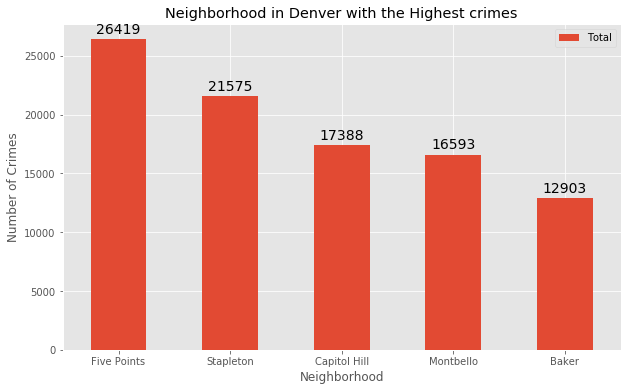

In [20]:
per_neigh = crime_neigh_top5[['Neighbourhood','Total']]

per_neigh.set_index('Neighbourhood',inplace = True)

ax = per_neigh.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Neighborhood')
ax.set_title('Neighborhood in Denver with the Highest crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

In [21]:
crime_neigh_low = Dnvr_negh_crime.tail(5)
crime_neigh_low

,Neighbourhood,YearAccessory Conspiracy To Crime,YearAgg Aslt Police Weapon,YearAggravated Assault,YearAggravated Assault Dv,YearAltering Vin Number,YearAnimal Cruelty To,YearAnimal Poss Of Dangerous,YearArson Business,YearArson Other,...,YearWeapon Fire Into Occ Bldg,YearWeapon Fire Into Occ Veh,YearWeapon Flourishing,YearWeapon Other Viol,YearWeapon Poss Illegal Dangerous,YearWeapon Unlawful Discharge Of,YearWeapon Unlawful Sale,YearWindow Peeping,YearWiretapping,Total
47,Skyland,0,0,22,5,0,1,0,0,2,...,9,3,0,1,6,57,0,0,0,1946
45,Rosedale,0,0,9,3,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1571
18,Country Club,0,0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1123
65,Wellshire,0,0,3,2,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,604
31,Indian Creek,0,0,0,2,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,573


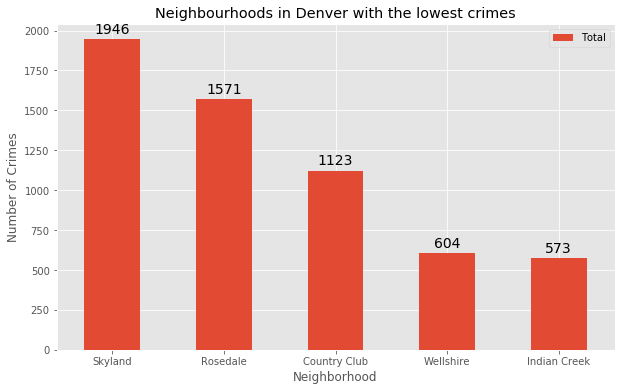

In [22]:
per_neigh = crime_neigh_low[['Neighbourhood','Total']]

per_neigh.set_index('Neighbourhood',inplace = True)

ax = per_neigh.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Neighborhood')
ax.set_title('Neighbourhoods in Denver with the lowest crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

In [23]:
Dnvr_cat = pd.pivot_table(df_merged,
                               values=['Year'],
                               index=['Borough'],
                               columns=['Type'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)
Dnvr_cat

Year                         \
Type      Accessory Conspiracy To Crime Agg Aslt Police Weapon   
Borough                                                          
Central                              27                    128   
East                                  8                     13   
North                                13                     35   
Northeast                             9                     20   
Northwest                             4                     19   
South                                 6                      3   
Southeast                             4                      3   
Southwest                             9                      9   
West                                 17                     37   
All                                  97                    267   

                                                                        \
Type      Aggravated Assault Aggravated Assault Dv Altering Vin Number   
Borough                                                                  
Central                 1633                   365                   1   
East                     368                   266                   0   
North                    964                   257                   0   
Northeast                461                   218                   0   
Northwest                297                   146                   0   
South                    163                    54                   0   
Southeast                160                   212                   0   
Southwest                175                   131                   0   
West                     715                   362                   0   
All                     4936                  2011                   1   

                                                                     \
Type      Animal Cruelty To Animal Poss Of Dangerous Arson Business   
Borough                                                               
Central                  28                        3             14   
East                     15                        1             12   
North                    21                        1              8   
Northeast                10                        2              5   
Northwest                 8                        0              6   
South                     6                        1              3   
Southeast                 8                        0              0   
Southwest                 6                        0              1   
West                     25                        4              8   
All                     127                       12             57   

                                             ...                            \
Type      Arson Other Arson Public Building  ... Weapon Fire Into Occ Bldg   
Borough                                      ...                             
Central            46                     5  ...                        28   
East               16                     1  ...                        33   
North              30                     2  ...                       127   
Northeast          17                     2  ...                       147   
Northwest          16                     1  ...                        40   
South               7                     1  ...                        10   
Southeast          10                     0  ...                        28   
Southwest           9                     0  ...                        29   
West               38                     3  ...                       114   
All               189                    15  ...                       556   

                                                                         \
Type      Weapon Fire Into Occ Veh Weapon Flourishing Weapon Other Viol   
Borough                                                                   
Central                         15               

In [24]:
Dnvr_cat.reset_index(inplace=True)
Dnvr_cat.columns = Dnvr_cat.columns.map(''.join)
Dnvr_cat.columns = Dnvr_cat.columns.str.replace(r'^Year', '')
Dnvr_cat = Dnvr_cat.head(5)
Dnvr_cat

,Borough,Accessory Conspiracy To Crime,Agg Aslt Police Weapon,Aggravated Assault,Aggravated Assault Dv,Altering Vin Number,Animal Cruelty To,Animal Poss Of Dangerous,Arson Business,Arson Other,...,Weapon Fire Into Occ Bldg,Weapon Fire Into Occ Veh,Weapon Flourishing,Weapon Other Viol,Weapon Poss Illegal Dangerous,Weapon Unlawful Discharge Of,Weapon Unlawful Sale,Window Peeping,Wiretapping,All
0,Central,27,128,1633,365,1,28,3,14,46,...,28,15,92,87,197,162,1,20,0,112386
1,East,8,13,368,266,0,15,1,12,16,...,33,10,14,29,29,242,0,10,0,41505
2,North,13,35,964,257,0,21,1,8,30,...,127,41,48,56,105,627,0,5,1,53085
3,Northeast,9,20,461,218,0,10,2,5,17,...,147,29,27,82,81,569,0,7,1,46893
4,Northwest,4,19,297,146,0,8,0,6,16,...,40,8,15,22,53,127,1,12,0,42309


## Which borough have highest crimes

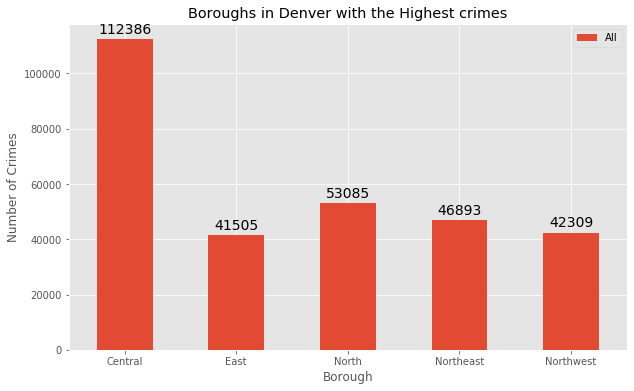

In [25]:
per_borough = Dnvr_cat[['Borough','All']]

per_borough.set_index('Borough',inplace = True)

ax = per_borough.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Borough')
ax.set_title('Boroughs in Denver with the Highest crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

In [26]:
df1111=Dnvr_cat.loc[:, Dnvr_cat.columns.str.contains('Business')]
df1111

,Arson Business,Burglary Business By Force,Burglary Business No Force,Robbery Business
0,14,939,533,277
1,12,477,143,172
2,8,478,215,133
3,5,374,149,198
4,6,455,182,123


# We choose Northwest because there low crime type against Business.


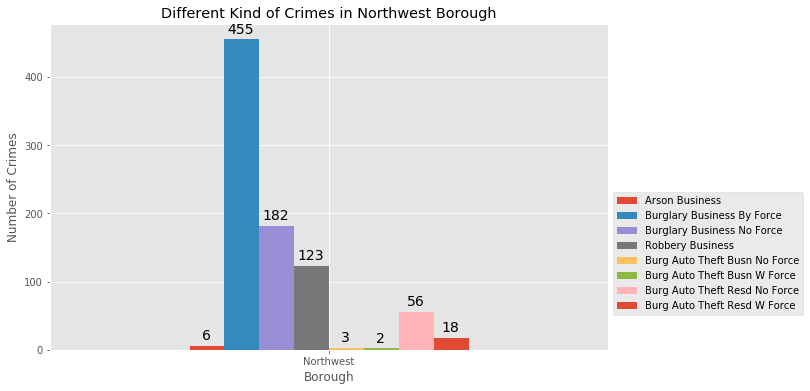

In [27]:
 Dnvr_nw = Dnvr_cat[Dnvr_cat['Borough'] == 'Northwest']

 Dnvr_nw = Dnvr_nw.sort_values(['All'], ascending = True, axis = 0)

Dnvr_nw_df = Dnvr_nw[['Borough','Arson Business', 'Burglary Business By Force',
                      'Burglary Business No Force', 'Robbery Business', 'Burg Auto Theft Busn No Force',
 'Burg Auto Theft Busn W Force', 'Burg Auto Theft Resd No Force', 'Burg Auto Theft Resd W Force',]]


Dnvr_nw_df.set_index('Borough',inplace = True)

ax = Dnvr_nw_df.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Borough')
ax.set_title('Different Kind of Crimes in Northwest Borough')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=3), 
                (p.get_x()+p.get_width()/3., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(5, 10), 
                textcoords='offset points',
                fontsize = 14
               )
    ax.legend(loc='upper left', bbox_to_anchor=(1.00, 0.5))

plt.show()

In [28]:
Dnvr_nw_neighb = df_merged

Dnvr_nw_neighb = Dnvr_nw_neighb[Dnvr_nw_neighb['Borough'] == 'Northwest']
Dnvr_nw_neighb.reset_index(inplace=True, drop=True)

print('Number of Neighborhoods in Nortwest Borough', len(Dnvr_nw_neighb['Neighbourhood'].unique()))

Dnvr_nw_neighb['Neighbourhood'].unique()

Number of Neighborhoods in Nortwest Borough 9


array(['Sunnyside', 'Regis', 'West Highland', 'Chaffee Park', 'Highland',
       'Berkeley', 'Jefferson Park', 'Auraria', 'Sloan Lake'],
      dtype=object)

In [29]:
Latitude = []
Longitude = []
Borough = []
Neighborhood = Dnvr_nw_neighb['Neighbourhood'].unique()



key = '0bac9324852d4598ab4ef4aa6fa24434'
geocoder = OpenCageGeocode(key)

for i in range(len(Neighborhood)):
    address = '{}, Denver, CO, US'.format(Neighborhood[i])
    location = geocoder.geocode(address)
    Latitude.append(location[0]['geometry']['lat'])
    Longitude.append(location[0]['geometry']['lng'])
    Borough.append('Northwest')
print(Latitude, Longitude)



[39.7756802, 39.7867787, 39.7644656, 39.787909, 39.761583, 39.7752306, 39.7506207, 39.7465219, 39.7524265] [-105.0116958, -105.0439679, -105.039271, -105.0109935, -105.0125003, -105.0392611, -105.0197793, -105.0067102, -105.0392402]


In [30]:
nw_dict = {'Neighbourhood': Neighborhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
nw_neig_geo = pd.DataFrame(data=nw_dict, columns=['Neighbourhood', 'Borough', 'Latitude', 'Longitude'], index=None)

nw_neig_geo

,Neighbourhood,Borough,Latitude,Longitude
0,Sunnyside,Northwest,39.775680,-105.011696
1,Regis,Northwest,39.786779,-105.043968
2,West Highland,Northwest,39.764466,-105.039271
3,Chaffee Park,Northwest,39.787909,-105.010993
4,Highland,Northwest,39.761583,-105.012500
5,Berkeley,Northwest,39.775231,-105.039261
6,Jefferson Park,Northwest,39.750621,-105.019779
7,Auraria,Northwest,39.746522,-105.006710
8,Sloan Lake,Northwest,39.752426,-105.039240


In [31]:
address = 'Denver, CO, US'

location = geocoder.geocode(address)
latitude = location[0]['geometry']['lat']
longitude = location[0]['geometry']['lng']

print('The geograpical coordinate of Denver, US are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Denver, US are 39.7392364, -104.9848623.


In [32]:
Denv_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(nw_neig_geo['Latitude'], nw_neig_geo['Longitude'], nw_neig_geo['Borough'], nw_neig_geo['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#31cc55',
        fill_opacity=0.7,
        parse_html=False).add_to(Denv_map)  
    
Denv_map

## Foursquare API

In [33]:
CLIENT_ID = 'X2W3SWASDVIE5Q1LIBPF4YVSBZU5CZ2X5WWVCQIQEPHECQWR'
CLIENT_SECRET = 'J0BAE4CAVDKCXJKGEADNH1NVB1B05URMIVZIQDEJZA2AXLPF'
VERSION = '20200621'
LIMIT = 100


In [34]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Category']
    
    return(nearby_venues)

In [35]:
Dnvr_nw_venues = getNearbyVenues(names=nw_neig_geo['Neighbourhood'],
                                   latitudes=nw_neig_geo['Latitude'],
                                   longitudes=nw_neig_geo['Longitude']
                                  )

Sunnyside
Regis
West Highland
Chaffee Park
Highland
Berkeley
Jefferson Park
Auraria
Sloan Lake


In [36]:
print(Dnvr_nw_venues.shape)
Dnvr_nw_venues.head()

(186, 5)


,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Category
0,Sunnyside,39.77568,-105.011696,Chaffee Park,Park
1,Sunnyside,39.77568,-105.011696,The Wolf's Tailor,Restaurant
2,Sunnyside,39.77568,-105.011696,Chickee's Lil Kitchen,Cajun / Creole Restaurant
3,Sunnyside,39.77568,-105.011696,Huckleberry Roasters,Coffee Shop
4,Sunnyside,39.77568,-105.011696,Cherry Bean,Coffee Shop


In [37]:
Dnvr_nw_venues.groupby('Neighbourhood').count().drop(['Neighborhood Latitude','Neighborhood Longitude','Venue Category'], axis = 1)

,Venue
Neighbourhood,
Auraria,23
Berkeley,42
Chaffee Park,4
Highland,45
Jefferson Park,14
Regis,4
Sloan Lake,5
Sunnyside,24
West Highland,25


In [38]:
print('There are {} uniques categories.'.format(len(Dnvr_nw_venues['Venue Category'].unique())))

There are 91 uniques categories.


In [39]:
# one hot encoding
Dnvr_onehot = pd.get_dummies(Dnvr_nw_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Dnvr_onehot['Neighbourhood'] = Dnvr_nw_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [Dnvr_onehot.columns[-1]] + list(Dnvr_onehot.columns[:-1])
Dnvr_onehot = Dnvr_onehot[fixed_columns]

Dnvr_onehot.head()

,Neighbourhood,American Restaurant,Art Gallery,Asian Restaurant,BBQ Joint,Baby Store,Bakery,Bar,Baseball Field,Basketball Stadium,...,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Trade School,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,Sunnyside,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Sunnyside,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Sunnyside,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Sunnyside,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Sunnyside,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
Dnvr_nw_grouped = Dnvr_onehot.groupby('Neighbourhood').mean().reset_index()
Dnvr_nw_grouped

,Neighbourhood,American Restaurant,Art Gallery,Asian Restaurant,BBQ Joint,Baby Store,Bakery,Bar,Baseball Field,Basketball Stadium,...,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Trade School,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,Auraria,0.043478,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.086957,...,0.000000,0.000000,0.00000,0.043478,0.00,0.000000,0.000000,0.000000,0.00,0.000000
1,Berkeley,0.023810,0.02381,0.000000,0.02381,0.02381,0.023810,0.023810,0.000000,0.000000,...,0.000000,0.000000,0.02381,0.000000,0.00,0.000000,0.023810,0.000000,0.00,0.000000
2,Chaffee Park,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.250000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000
3,Highland,0.044444,0.00000,0.022222,0.00000,0.00000,0.022222,0.000000,0.000000,0.000000,...,0.022222,0.044444,0.00000,0.000000,0.00,0.022222,0.022222,0.022222,0.00,0.044444
4,Jefferson Park,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.071429,0.071429,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.071429
5,Regis,0.250000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.25,0.000000,0.000000,0.000000,0.00,0.000000
6,Sloan Lake,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.200000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.00,0.000000,0.000000,0.200000,0.00,0.000000
7,Sunnyside,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.041667,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000
8,West Highland,0.040000,0.00000,0.000000,0.00000,0.00000,0.000000,0.040000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.00,0.000000,0.000000,0.000000,0.04,0.000000


In [41]:
num_top_venues = 5

for hood in Dnvr_nw_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = Dnvr_nw_grouped[Dnvr_nw_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Auraria----
                  venue  freq
0  Fast Food Restaurant  0.13
1               Stadium  0.09
2            Sports Bar  0.09
3           Salad Place  0.09
4    Basketball Stadium  0.09


----Berkeley----
                venue  freq
0         Pizza Place  0.07
1      Breakfast Spot  0.05
2         Coffee Shop  0.05
3  Mexican Restaurant  0.05
4  Italian Restaurant  0.05


----Chaffee Park----
                        venue  freq
0  Construction & Landscaping  0.25
1           Convenience Store  0.25
2                         Bar  0.25
3                        Park  0.25
4                      Museum  0.00


----Highland----
                 venue  freq
0          Pizza Place  0.07
1  American Restaurant  0.04
2              Brewery  0.04
3             Tea Room  0.04
4     Sushi Restaurant  0.04


----Jefferson Park----
                venue  freq
0  Mexican Restaurant  0.14
1         Yoga Studio  0.07
2             Brewery  0.07
3              Museum  0.07
4                Par

In [42]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [43]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = Dnvr_nw_grouped['Neighbourhood']

for ind in np.arange(Dnvr_nw_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Dnvr_nw_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Auraria,Fast Food Restaurant,Basketball Stadium,Coffee Shop,Salad Place,Stadium,Sports Bar,Hot Dog Joint,Sporting Goods Shop,Brewery,Chinese Restaurant
1,Berkeley,Pizza Place,Brewery,Breakfast Spot,Coffee Shop,Mexican Restaurant,Italian Restaurant,American Restaurant,Liquor Store,Park,Outdoor Supply Store
2,Chaffee Park,Park,Construction & Landscaping,Convenience Store,Bar,Yoga Studio,Flower Shop,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Dessert Shop
3,Highland,Pizza Place,Yoga Studio,Sushi Restaurant,Beer Garden,Brewery,Cocktail Bar,Coffee Shop,Italian Restaurant,New American Restaurant,American Restaurant
4,Jefferson Park,Mexican Restaurant,Yoga Studio,Brewery,Italian Restaurant,Museum,Comedy Club,Park,Café,Salon / Barbershop,Seafood Restaurant


## Cluster Neighborhoods

In [44]:
# set number of clusters
kclusters = 5

Dnvr_grouped_clustering = Dnvr_nw_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Dnvr_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 0, 1, 0, 0, 3, 2, 0, 0])

In [45]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Dnvr_merged = nw_neig_geo

# merge toronto_grouped with Vancouver data to add latitude/longitude for each neighborhood
Dnvr_merged = Dnvr_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

Dnvr_merged.head()

,Neighbourhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Sunnyside,Northwest,39.775680,-105.011696,0,Coffee Shop,Mexican Restaurant,Breakfast Spot,New American Restaurant,Park,Grocery Store,Cheese Shop,Ramen Restaurant,Restaurant,Cajun / Creole Restaurant
1,Regis,Northwest,39.786779,-105.043968,3,American Restaurant,Convenience Store,Thrift / Vintage Store,Golf Course,Fast Food Restaurant,Comedy Club,Construction & Landscaping,Cosmetics Shop,Cupcake Shop,Deli / Bodega
2,West Highland,Northwest,39.764466,-105.039271,0,Pizza Place,Mexican Restaurant,Coffee Shop,Sushi Restaurant,Spa,Wings Joint,Food Truck,Indian Restaurant,Flower Shop,Fast Food Restaurant
3,Chaffee Park,Northwest,39.787909,-105.010993,1,Park,Construction & Landscaping,Convenience Store,Bar,Yoga Studio,Flower Shop,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Dessert Shop
4,Highland,Northwest,39.761583,-105.012500,0,Pizza Place,Yoga Studio,Sushi Restaurant,Beer Garden,Brewery,Cocktail Bar,Coffee Shop,Italian Restaurant,New American Restaurant,American Restaurant


In [46]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Dnvr_merged['Latitude'], Dnvr_merged['Longitude'], Dnvr_merged['Neighbourhood'], Dnvr_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Analysis

## Cluster 1

In [47]:
Dnvr_merged.loc[Dnvr_merged['Cluster Labels'] == 0, Dnvr_merged.columns[[1] + list(range(5, Dnvr_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Northwest,Coffee Shop,Mexican Restaurant,Breakfast Spot,New American Restaurant,Park,Grocery Store,Cheese Shop,Ramen Restaurant,Restaurant,Cajun / Creole Restaurant
2,Northwest,Pizza Place,Mexican Restaurant,Coffee Shop,Sushi Restaurant,Spa,Wings Joint,Food Truck,Indian Restaurant,Flower Shop,Fast Food Restaurant
4,Northwest,Pizza Place,Yoga Studio,Sushi Restaurant,Beer Garden,Brewery,Cocktail Bar,Coffee Shop,Italian Restaurant,New American Restaurant,American Restaurant
5,Northwest,Pizza Place,Brewery,Breakfast Spot,Coffee Shop,Mexican Restaurant,Italian Restaurant,American Restaurant,Liquor Store,Park,Outdoor Supply Store
6,Northwest,Mexican Restaurant,Yoga Studio,Brewery,Italian Restaurant,Museum,Comedy Club,Park,Café,Salon / Barbershop,Seafood Restaurant


## Cluster 2

In [48]:
Dnvr_merged.loc[Dnvr_merged['Cluster Labels'] == 1, Dnvr_merged.columns[[1] + list(range(5, Dnvr_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Northwest,Park,Construction & Landscaping,Convenience Store,Bar,Yoga Studio,Flower Shop,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Dessert Shop


## Cluster 3

In [49]:
Dnvr_merged.loc[Dnvr_merged['Cluster Labels'] == 2, Dnvr_merged.columns[[1] + list(range(5, Dnvr_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Northwest,Wine Shop,Garden Center,Garden,Bar,Scenic Lookout,Yoga Studio,Electronics Store,Comedy Club,Construction & Landscaping,Convenience Store


## Cluster 4

In [50]:
Dnvr_merged.loc[Dnvr_merged['Cluster Labels'] == 3, Dnvr_merged.columns[[1] + list(range(5, Dnvr_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Northwest,American Restaurant,Convenience Store,Thrift / Vintage Store,Golf Course,Fast Food Restaurant,Comedy Club,Construction & Landscaping,Cosmetics Shop,Cupcake Shop,Deli / Bodega


## Cluster 5

In [51]:
Dnvr_merged.loc[Dnvr_merged['Cluster Labels'] == 4, Dnvr_merged.columns[[1] + list(range(5, Dnvr_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Northwest,Fast Food Restaurant,Basketball Stadium,Coffee Shop,Salad Place,Stadium,Sports Bar,Hot Dog Joint,Sporting Goods Shop,Brewery,Chinese Restaurant


## Results and Discussion <a name="results"></a>

Our analysis shows that Northwest a good borough that include good neighbourhoods with different venue. Its a very good borough with low crime level and different types and various leisure options.
Also that places very close to center of Denver, and have well space for commercial business. 



## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify Denver areas close to center with low crime level for opening there business in order to aid stakeholders in narrowing down the search for optimal location. By calculating most common venue in Northwest from Foursquare data we have first identified types of commercial places, and then generated extensive collection of locations which satisfy some basic requirements. Clustering of those locations was then performed in order to create major zones of interes and addresses of those zone centers were created to be used as starting points for final exploration by stakeholders.

Final decission on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.